# Creación modelo predictivo para la tasa de cancelación de clientes

En SKC Maquinarias nos interesa medir la tasa de retención de clientes para el área de repuestos, pero como valor adicional se desarrolló un modelo predictivo el cual calcula cuál es la probabilidad que un cliente deje de comprar y cuanto se dejará de ganar por este concepto

In [10]:
#importamos las siguientes librerías
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, make_scorer
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from scipy import interp
from matplotlib.pyplot import *

## Entendiendo nuestro DataFrame

Como primer paso Leemos el archivo con los datos, verificamos el tipo de dato de cada variable y visualizamos algunos estadísticas básicas del dataframe

In [11]:
#ruta del archivo con los datos
ruta='C:\Users\alfredo\Git\Churn\loans'

In [13]:
#nombre de las columnas
columns_name=['pk', 'sociedad', 'sector', 'ofvta', 'cod_cliente', 'nombre', 'vendedor', 'clas_fiscal', 'pedido', 'material', 'marca', 'linea', 'linea_o', 'id_pedido', 'costo', 'gr_mat', 'fecha', 'fecha_2', 'ingreso', 'mesn', 'dia', 'mes', 'año', 'funica' ]

In [14]:
df=pd.read_csv(ruta+'/Query1.txt', sep=';', decimal=',', encoding = 'ISO-8859-1', names=columns_name, header=0)

In [15]:
#imprimimos las 5 primeras filas del dataframe
df.head()

,pk,sociedad,sector,ofvta,cod_cliente,nombre,vendedor,clas_fiscal,pedido,material,...,costo,gr_mat,fecha,fecha_2,ingreso,mesn,dia,mes,año,funica
0,1331712,CC07,S2,G04,150230,M.O.P. DIRECCION DE VIALIDAD,ST,ZF01,CONCEPCION,150897063,...,91.94,NaN,30/10/2015,2015.10.01 00:00:00,136.54,2015-10-01,30,10,2015,201510
1,1331717,CC07,S2,G92,233597,Maquinarias y Servicios Alianza Lim,ST,ZF01,IQUIQUE,151185911,...,0.00,NaN,30/10/2015,2015.10.01 00:00:00,0.00,2015-10-01,30,10,2015,201510
2,1331699,CC07,S2,G04,71296,WTY_VOLVO BRASIL,ST,ZF01,CONCEPCION,151004930,...,0.00,NaN,19/10/2015,2015.10.01 00:00:00,0.00,2015-10-01,19,10,2015,201510
3,1331701,CC07,S2,G10,150262,M.O.P. DIRECCION DE VIALIDAD,ST,ZF01,TALCA,151014216,...,0.00,NaN,30/10/2015,2015.10.01 00:00:00,0.00,2015-10-01,30,10,2015,201510
4,1331724,CC07,S2,G14,263052,BRANDA SERVICIOS LIMITADA,ST,ZF01,SERENA,150902447,...,152.85,NaN,30/10/2015,2015.10.01 00:00:00,188.04,2015-10-01,30,10,2015,201510


In [16]:
#verificamos los tipos de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149302 entries, 0 to 149301
Data columns (total 24 columns):
pk             149302 non-null int64
sociedad       149302 non-null object
sector         149302 non-null object
ofvta          149302 non-null object
cod_cliente    149302 non-null object
nombre         149302 non-null object
vendedor       149302 non-null object
clas_fiscal    77062 non-null object
pedido         149295 non-null object
material       149299 non-null object
marca          149302 non-null object
linea          149302 non-null object
linea_o        149302 non-null object
id_pedido      143160 non-null object
costo          149302 non-null float64
gr_mat         144412 non-null object
fecha          149302 non-null object
fecha_2        149302 non-null object
ingreso        149302 non-null float64
mesn           149302 non-null object
dia            149302 non-null int64
mes            149302 non-null int64
año            149302 non-null int64
funica         149

In [17]:
#modificamos el formato de las siguientes variables a "category" para  ahorrar un poco más de memoria 
df[['sociedad', 'sector', 'ofvta', 'clas_fiscal', 'marca', 'linea', 'linea_o']]=df[['sociedad', 'sector', 'ofvta', 'clas_fiscal', 'marca', 'linea', 'linea_o']].apply(lambda x: x.astype('category'))


In [18]:
#transformo la fecha a formato date
df['Fecha_factura']=pd.to_datetime(df['fecha'], format='%d/%m/%Y')

In [19]:
#modifico el formato de los ingresos y costos
df[['ingreso', 'costo']] = df[['ingreso', 'costo']].apply(lambda x: x.astype(np.int64))

In [20]:
#elimino los registros con ingreso 0 en las filas (esto es un error del ERP)
df=df[df.ingreso != 0.0]

In [21]:
#imprimo estadísticos básicos de venta
df[['ingreso']].groupby(lambda x: df['Fecha_factura'][x].year).describe()

ingreso                                                               
        count        mean          std      min   25%   50%    75%       max
2015  36139.0  330.435513  1803.550249 -12579.0  33.0  89.0  253.0  166287.0
2016  38342.0  328.159851  1288.282513 -11942.0  27.0  88.0  253.0   64582.0

Estimados que un cliente no debría pasar de seis meses sin comprar repuestos por lo que dividimos el dataframe en dos considerando los movimientos históricos de seis meses y un holdout de seis meses

In [25]:
#selecciono fecha de la historia y el forecast
startDate_history = datetime.strptime('20150301', '%Y%m%d').date()
endDate_history=datetime.strptime('20150831', '%Y%m%d').date()

startDate_forecast = datetime.strptime('20150901','%Y%m%d').date()
endDate_forecast = datetime.strptime('20160229','%Y%m%d').date()

## Funciones específicas

Creamos algunas funciones que noa ayudaran a realizar operaciones complejas de data wrangling y que nos seviran más adelante

In [29]:
def getRFM(dataFrame, sDate, eDate): 
    """
    Función que calcula la frecuencia, ingreso, la recencia de compra y si utilizó servicio técnico
    """
    #ordeno el dataframe por fecha descendiente
    dataFrame=dataFrame.sort_values(by='Fecha_factura', ascending=False)
    #filtro los datos segun la fecha histórica y los almaceno en un df temporal
    tmpdf=dataFrame[(dataFrame.Fecha_factura >= sDate) & (dataFrame.Fecha_factura <= eDate)]
    #elimino filas con los ID duplicados, asigno a una nuevo df modifico el indice para que sea los ID de cliente
    newdf=tmpdf.drop_duplicates(['cod_cliente']).set_index(['cod_cliente'])
    
    #calculo la recencia (días), menores días significa más reciente
    newdf['recency']=(eDate-newdf['Fecha_factura']).dt.days
    #calculo la frecuencia de compra   
    frecuency=tmpdf.groupby(['cod_cliente'] )['cod_cliente'].count()
    #join la variable frecuencia con newdf
    newdf=newdf.join(frecuency)
    #renombro las columnas
    newdf=newdf.rename(columns={'cod_cliente': 'frecuency'})
    
    #calculo el ingreso
    monetary=tmpdf.groupby(['cod_cliente'] )[['cod_cliente','ingreso']].sum()    
    newdf=newdf.merge(monetary, left_index=True,right_index=True)
    newdf=newdf.rename(columns={'ingreso_y': 'monetary'})    
    
    #calculo si utilizó servicio técnico
    tmpdf.is_copy = None
    tmpdf['servicio_tecnico']=tmpdf.sector.apply(lambda x: 1 if x=='S2' else 0)  
    sector=tmpdf.loc[:, ['cod_cliente','servicio_tecnico']].sort_values(by='servicio_tecnico', ascending=False)
    sector=sector.drop_duplicates(['cod_cliente'])
    sector=sector.set_index(['cod_cliente'])
    newdf=newdf.join(sector)   
    
    #returno un nuevo df con la recencia, frecuencia, ingreso y st
    return newdf

In [31]:
def plotROC(model, X, y):
    """
    Evalúo la performance del predictor con 5-fold cross-validation y gráfico la media del resultado de la curva ROC
    """
    cv = StratifiedKFold(n_splits=10, shuffle=True)
    classifier = model

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    for train, test in cv.split(X, y):
        prob = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # calculo la curva de ROC y el AUC
        fpr, tpr, thresholds = roc_curve(y[test], prob[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        pred_churn = prob[:, 1]
        
    # gráfico la curva ROC
    mean_tpr /= 10
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, '-', label='Promedio ROC (area = %0.2f)' % mean_auc, lw=2)

    plt.xlim([0, 1.0])
    plt.ylim([0, 1.0])
    plt.xlabel('Falso positivo')
    plt.ylabel('Verdadero positivo')
    plt.legend(loc="lower right")
    plt.show()
    #retorno probabilidad para testing
    return pred_churn

In [32]:
def classification_report_with_accuracy_score(y_true, y_pred):
    """
    función que entrega el accuracy
    """
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    
    return accuracy_score(y_true, y_pred)

In [34]:
def ChurnModel(history, model, X, y):
    """
    Cálculo la tasa de cancelación de clientes y su perdida
    """
    # modelo
    clf = model
    clf = clf.fit(X,y)
    churn_prob = clf.predict_proba(X)
    history['churn_prob'] = churn_prob[:,1]
    
    # calculo la perdida
    history['expected_loss'] = history['churn_prob'] * history['monetary']
   
    
    # retorno un df con la probabilidad, y la expectativa de perdida
    return history

In [36]:
#llamamos a la función getrfm
historia=getRFM(df, startDate_history, endDate_history)
pronostico=getRFM(df, startDate_forecast, endDate_forecast)

Construimos nuestra variable a predecir

In [38]:
#nueva variable de compra, será la variable a predecir
historia['buy']=0
#Encuentro aquellos que volvieron a comprar en el pronóstico
historia['buy']=historia.index.isin(pronostico.index)
historia['buy']=historia['buy'].astype(int)

In [40]:
#proporción de los clientes que compran
compra_tab=pd.crosstab(historia['buy'], columns='count')
print(compra_tab)

col_0  count
buy         
0        319
1        585


In [42]:
#proporción de la variable compra
print(compra_tab/compra_tab.sum()) 

col_0     count
buy            
0      0.352876
1      0.647124


## Análisis exploratorio

Realizamos un análisis exploratorio gráficando las variables para ver si tienen outlaiers, que es lo más seguro especialmente en los clientes con grandes flotas de equipos

In [58]:
#estadísticos básicos de mis variables
historia[['recency', 'frecuency', 'monetary', 'buy']].describe()

,recency,frecuency,monetary,buy
count,904.000000,904.000000,904.000000,904.000000
mean,57.429204,20.702434,7099.228982,0.647124
std,51.489846,75.760836,33055.987565,0.478129
min,0.000000,1.000000,-603.000000,0.000000
25%,12.000000,2.000000,233.500000,0.000000
50%,41.500000,5.000000,643.000000,1.000000
75%,95.000000,13.000000,2526.250000,1.000000
max,182.000000,1487.000000,542620.000000,1.000000


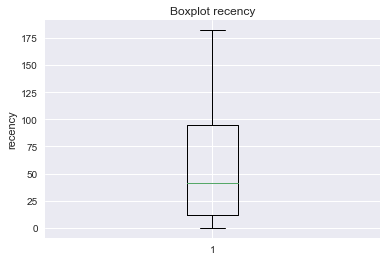

In [49]:
%matplotlib inline

#boxplot recency
plt.boxplot(historia['recency'])
plt.title('Boxplot recency')
plt.ylabel('recency')

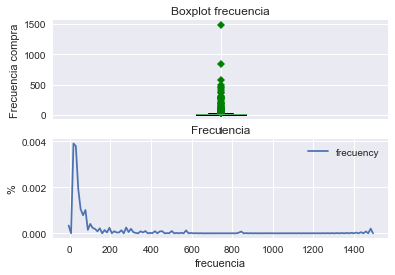

In [64]:
#gráfico frecuencia
plt.figure(1)
plt.subplot(2, 1, 1)
plt.boxplot(historia['frecuency'], 0, 'gD')
plt.title('Boxplot frecuencia')
plt.ylabel('Frecuencia compra')

plt.subplot(2, 1, 2)
sns.kdeplot(historia['frecuency'])
plt.title("Frecuencia") 
plt.ylabel('%')
plt.xlabel('frecuencia')
plt.show()

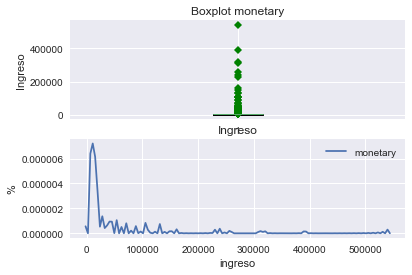

In [65]:
#gráfico monetary
plt.subplot(2, 1, 1)
plt.boxplot(historia['monetary'], 0, 'gD')
plt.title('Boxplot monetary')
plt.ylabel('Ingreso')

plt.subplot(2, 1, 2)
sns.kdeplot(historia['monetary'])
plt.title("Ingreso") 
plt.ylabel('%')
plt.xlabel('ingreso')
plt.show()


## Construyendo el modelo predictivo

Comenzamos a construir nuestro modelo comparando modelos de caja blanca y caja negra, revisando cual entrega los mejores resultados. los modelos que utilizaremos serán regresión logística, máquinas de soporte vectorial y bosques aleatorios.

In [67]:
#selecciono las variables para construir el modelo
X=historia.loc[:, ['recency', 'frecuency', 'monetary', 'servicio_tecnico']]
y=historia.loc[:, 'buy']

In [70]:
#estandarizo las variables
seed = 10
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [73]:
#preparo los modelos
param_grid_rf ={ 'n_estimators': [200, 700], 'max_features': ['auto', 'sqrt', 'log2'],'max_depth' : [None, 10,20]
    }

param_grid_svm = {'kernel':('linear', 'rbf'), 'C':[1,2,3,4,5,6,7,8,9,10], 'gamma': 
              [0.01,0.02,0.03,0.04,0.05,0.10,0.2,0.3,0.4,0.5]
              }
    
param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
    

In [74]:
#seleccionamos el mejor parámetro para los bosques aleatorios
rf=RandomForestClassifier()
estimacion_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_grid_rf, cv= 5)
estimacion_rf.fit(X, y)
print (estimacion_rf.best_params_)


{'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 10}


In [77]:
#seleccionamos el mejor parámetro para svm
sv=SVC()
estimacion_svm = RandomizedSearchCV(estimator=sv, param_distributions=param_grid_svm, cv= 5)
estimacion_svm.fit(X, y)
print (estimacion_svm.best_params_)

{'kernel': 'linear', 'gamma': 0.3, 'C': 6}


In [79]:
#seleccionamos el mejor parámetro para regresión logística
lr=LogisticRegression()
estimacion_lr = RandomizedSearchCV(estimator=lr, n_iter=7,  param_distributions=param_grid_lr, cv= 5)
estimacion_lr.fit(X, y)
print (estimacion_lr.best_params_)

{'C': 0.001}


In [81]:
#guardo los modelos
modelos = []
modelos.append(('LR', LogisticRegression(C=0.001)))
modelos.append(('SVC', SVC(kernel= 'linear', gamma= 0.1, C= 10)))
modelos.append(('RF', RandomForestClassifier(n_estimators= 200, max_features= 'sqrt', max_depth= 10)))

In [83]:
#evalúo el modelo

resultados=[]
nombres=[]
scoring = 'accuracy'
originalclass = []
predictedclass = []

for nombre, modelo in modelos:
    shuffle_split = ShuffleSplit(test_size=.75, train_size=.25, n_splits=10, random_state=seed)
    cv_resultados = cross_val_score(modelo, X, y, cv=shuffle_split, scoring=make_scorer(classification_report_with_accuracy_score))
    resultados.append(cv_resultados)
    nombres.append(nombre)
    msg = ("%s %f (%f)" % (nombre, cv_resultados.mean(), cv_resultados.std()))
    print(msg)

LR 0.703835 (0.004365)
SVC 0.713274 (0.006861)
RF 0.691740 (0.015200)


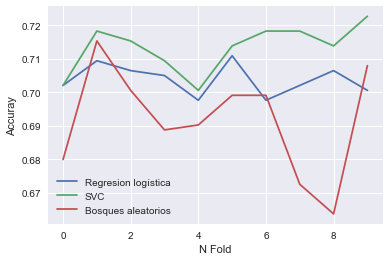

In [88]:
#graficamos el acuracy en los 10 k fold-cross validation
plt.plot(resultados[0], label='Regresion logística')
plt.plot(resultados[1], label='SVC')
plt.plot(resultados[2], label='Bosques aleatorios')
plt.ylabel('Accuray')
plt.xlabel('N Fold')
plt.legend(loc=3)
plt.show()

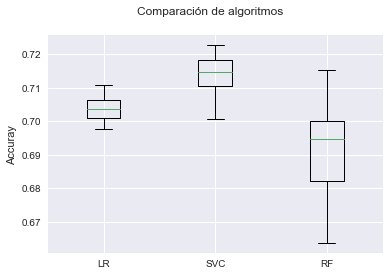

In [90]:
#graficamos los resultados de los tres modelos
fig = plt.figure()
fig.suptitle('Comparación de algoritmos')
ax = fig.add_subplot(111)
plt.ylabel('Accuray')
plt.boxplot(resultados)
ax.set_xticklabels(nombres)
plt.show()

los mejores resultados los entrega el modelo de SVM, con el que trabajaremos la parte final del modelo